[View in Colaboratory](https://colab.research.google.com/github/PGrabinski/XRayPneumonia/blob/master/X_Ray.ipynb)

# Chest X-Ray images dataset
### Pneumonia detection model

Dataset taken from [Kaggle Datasets: Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

The dataset contains 5683 X-Ray images divided into two classes: *normal* and *pneumonia*.
With addition that the pneumonia can be caused either by bacteria or by viruses what changes the pictured tissues in two different ways.

![Chest X-Ray examples](https://i.imgur.com/jZqpV51.png)



Originally this set is divided into train, validation and test sets. But the validation set contains only $8+8$ samples with a bad statistics what leads to inefficient validation. To bypass the problem, I copied the validation set into the train and started using cross validation.

## Data download
I store the dataset on my Google Drive. To get this data into to VM, I download it via PyDrive into the corresponing folders

In [0]:
def driveSetUp():
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive
drive = driveSetUp()

In [0]:
def downloadFilesFromFolderByID(folder_id, folder_name):
  drive = driveSetUp()
  import os, sys
  os.makedirs(os.path.join(folder_name, 'normal'), exist_ok=True)
  os.makedirs(os.path.join(folder_name, 'virus'), exist_ok=True)
  os.makedirs(os.path.join(folder_name, 'bacteria'), exist_ok=True)
  listed = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  for i, file in enumerate(listed):
    file = drive.CreateFile({'id':file['id']})
    file_path = folder_name + '/'
    if 'virus' in file['title']:
      file_path += 'virus/virus{}'.format(i)
    elif 'bacteria' in file['title']:
      file_path += 'bacteria/bacteria{}'.format(i)
    else:
      file_path += 'normal/normal{}'.format(i)
    file.GetContentFile('{}.jpg'.format(file_path))
  print('Files from the folder of id: {} have been downloaded into {}.'.format(folder_id, folder_name))

In [0]:
folders_to_download = [
#     {'id': '1EbT3bes4ONvGQvfI9oI_d-kmV42vYsU_', 'name': 'test'}, #NORMAL
#     {'id': '1jerX6X-ugSY8KqNbDO6hDOdarncp-8Di', 'name': 'test'}, #PNEUMONIA
     {'id': '1onNxF1RQ6Eex7snIs2NPFuO7qcFLGb_c', 'name': 'train'}, #NORMAL
    {'id': '1pXT_pdjWjHNJ5JleOD0dTviafaUWfSGF', 'name': 'train'}, #PNEUMONIA
]

In [0]:
for folder in folders_to_download:
  downloadFilesFromFolderByID(folder['id'], folder['name'])

## Data loading
Here, we load the downloaded images and immediatly rescale them into $300\times 210$ resolution. Some of the images are in three RGB channels and some are in the greyscale single chanel. We cast the single chanel into the RGB format.

In [7]:
import os
import numpy as np
from scipy import misc
from scipy import ndimage
import matplotlib.pylab as pylab
from keras.utils.np_utils import to_categorical

def loadImages(path, new_size=(150, 105)):
  images = []
  files = os.listdir(path)
  for file in files:
      temp_img = misc.imread(os.path.join(path, file))
      resized_img = misc.imresize(temp_img, new_size)
      if len(resized_img.shape) == 2:
        resized_img = np.stack((resized_img,)*3, axis=-1)
      images.append(resized_img)
  images_array = np.array(images)
  return images_array

def loadData():
  train_normal = loadImages('train/normal')
  train_virus = loadImages('train/virus')
  train_bacteria = loadImages('train/bacteria')
  
#   test_normal = loadImages('test/normal')
#   test_virus = loadImages('test/virus')
#   test_bacteria = loadImages('test/bacteria')
  
  train_targets = np.zeros(len(train_normal) + len(train_virus) + len(train_bacteria))
  train_targets[len(train_normal):len(train_normal)+len(train_virus)] = 1
  train_targets[len(train_normal)+len(train_virus):] = 2
  train_targets = to_categorical(train_targets)
  
#   test_targets = np.zeros(len(test_normal) + len(test_virus) + len(test_bacteria))
#   test_targets[len(test_normal):len(test_virus)] = 1
#   test_targets[len(test_virus):len(test_bacteria)] = 2
#   test_targets = to_categorical(test_targets)
                           
  
  train = np.concatenate((train_normal, train_virus, train_bacteria)).astype('float32')/255
#   test = np.concatenate((test_normal, test_virus, test_bacteria)).astype('float32')/255
  
  return train, train_targets#(train, train_targets, test, test_targets)

train_images, train_targets = loadData()
# (train_images, train_targets, test_images, test_targets) = loadData()

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


## Model definition

In [0]:
from keras import models
from keras import layers
from keras import optimizers
import numpy as np

def generateModel():
  model = models.Sequential()
  model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 105, 3)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(32, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))
#   model.summary()
  model.compile(optimizer = optimizers.RMSprop(lr=1e-5), loss = 'categorical_crossentropy', metrics=['acc'])
  return model

## Scikit-learn cross validation and learning

In [3]:
from sklearn.model_selection import StratifiedKFold as SKF
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

model = KerasClassifier(build_fn=generateModel, epochs=30, batch_size=1, verbose=0)
skf = SKF(n_splits=5, shuffle=True, random_state=1)
results = cross_val_score(model, train_images, train_targets, cv=skf)
print(results)
print(results.mean())

NameError: ignored

Problem with this approach is that we get only the epoch $30$ accuracy not the whole history over all epochs. This is the reason why I write my own k-folding.

## Saving and visualizing learning history data functions

In [0]:
def getLearningData(histories):
  val_acc = []
  acc = []
  val_loss = []
  loss = []

  for i in histories:
    val_acc.append(i.history['val_acc'])
    acc.append(i.history['acc'])
    val_loss.append(i.history['val_loss'])
    loss.append(i.history['loss'])

  data_to_save = {'acc': acc, 'val_acc': val_acc, 'loss': loss,'val_loss': val_loss}
  return data_to_save

In [0]:
def pickleHistories(histories, file_name):
  import pickle

  data_to_save = getLearningData(histories)  

  with open(file_name, 'wb') as outfile:
      pickle.dump(data_to_save, outfile)
  histories_file = drive.CreateFile()
  histories_file.SetContentFile(file_name)
  histories_file.Upload()

In [0]:
def plotHistories(histories):
  import matplotlib.pyplot as plt
  
  data_to_plot = getLearningData(histories)
  
  epochs = range(1, len(data_to_plot['acc'][0]) + 1)

  for acc in data_to_plot['val_acc']:
    plt.plot(epochs, acc, 'b')
  plt.title('Validation accuracy over {} different folds'.format(len(data_to_plot['acc'][0])))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.figure()

  plt.plot(epochs, np.mean(data_to_plot['val_acc'], axis=0), 'b', label='Validation')
  plt.plot(epochs, np.mean(data_to_plot['acc'], axis=0), 'r', label='Training')
  plt.title('Training and validation mean accuracy over {} different folds'.format(len(data_to_plot['acc'][0])))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.show()

## Self-written k-folding

In [0]:
from sklearn.utils import shuffle

def kFolding(k, modelGenerator, epochs, X, y):
  histories = []
  X_shuffled, y_shuffled = shuffle(X, y)
  partXLen = X_shuffled.shape[0]//k
  partyLen = y_shuffled.shape[0]//k
  for i in range(k):
    valX = X_shuffled[i * partXLen : (i + 1) * partXLen]
    trainX = np.concatenate([X_shuffled[: i * partXLen], X_shuffled[(i + 1) * partXLen:]])
    
    valy = y_shuffled[i * partyLen : (i + 1) * partyLen]
    trainy = np.concatenate([y_shuffled[: i * partyLen], y_shuffled[(i + 1) * partyLen:]])
    
    model = modelGenerator()
    history = model.fit(trainX, trainy, epochs=epochs, batch_size = 1, validation_data=(valX, valy))
    histories.append(history)
    print('Fold {} done. Final accuracy: {}.'.format((i + 1),history.history['val_acc'][-1]))
  return histories
  

### K=5 epochs=30

In [11]:
histories = kFolding(5, generateModel, 30, train_images, train_targets)

(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/30
3144/4212 [=====================>........] - ETA: 10s - loss: 1.0651 - acc: 0.4723

4212/4212 [==============================] - 46s 11ms/step - loss: 1.0593 - acc: 0.4782 - val_loss: 1.0464 - val_acc: 0.4753
Epoch 2/30
2080/4212 [=============>................] - ETA: 21s - loss: 1.0273 - acc: 0.4962

4212/4212 [==============================] - 45s 11ms/step - loss: 1.0164 - acc: 0.4893 - val_loss: 0.9734 - val_acc: 0.4886
Epoch 3/30
1702/4212 [===========>..................] - ETA: 25s - loss: 0.9341 - acc: 0.5582

4212/4212 [==============================] - 45s 11ms/step - loss: 0.9060 - acc: 0.5869 - val_loss: 0.8399 - val_acc: 0.6312
Epoch 4/30
1572/4212 [==========>...................] - ETA: 26s - loss: 0.8359 - acc: 0.6215

4212/4212 [==============================] - 45s 11ms/step - loss: 0.8131 - acc: 0.6303 - val_loss: 0.7793 - val_acc: 0.6426
Epoch 5/30
1511/4212 [=========>....................] - ETA: 27s - loss: 0.7783 - acc: 0.6532

4212/4212 [==============================] - 45s 11ms/step - loss: 0.7765 - acc: 0.6462 - val_loss: 0.7522 - val_acc: 0.6521
Epoch 6/30
1459/4212 [=========>....................] - ETA: 27s - loss: 0.7700 - acc: 0.6470

4212/4212 [==============================] - 45s 11ms/step - loss: 0.7595 - acc: 0.6538 - val_loss: 0.7344 - val_acc: 0.6625
Epoch 7/30
1487/4212 [=========>....................] - ETA: 27s - loss: 0.7421 - acc: 0.6631

4212/4212 [==============================] - 45s 11ms/step - loss: 0.7480 - acc: 0.6569 - val_loss: 0.7125 - val_acc: 0.6740
Epoch 8/30
1447/4212 [=========>....................] - ETA: 27s - loss: 0.7367 - acc: 0.6669

4212/4212 [==============================] - 45s 11ms/step - loss: 0.7294 - acc: 0.6750 - val_loss: 0.7378 - val_acc: 0.6587
Epoch 9/30
1485/4212 [=========>....................] - ETA: 27s - loss: 0.7330 - acc: 0.6795

4212/4212 [==============================] - 45s 11ms/step - loss: 0.7181 - acc: 0.6809 - val_loss: 0.6827 - val_acc: 0.7025
Epoch 10/30
1450/4212 [=========>....................] - ETA: 28s - loss: 0.7174 - acc: 0.6917

4212/4212 [==============================] - 45s 11ms/step - loss: 0.7042 - acc: 0.6963 - val_loss: 0.6744 - val_acc: 0.7034
Epoch 11/30
1472/4212 [=========>....................] - ETA: 27s - loss: 0.7072 - acc: 0.6984

4212/4212 [==============================] - 45s 11ms/step - loss: 0.6985 - acc: 0.7001 - val_loss: 0.6708 - val_acc: 0.7101
Epoch 12/30
1456/4212 [=========>....................] - ETA: 27s - loss: 0.6977 - acc: 0.6971

4212/4212 [==============================] - 45s 11ms/step - loss: 0.6859 - acc: 0.7032 - val_loss: 0.6529 - val_acc: 0.7177
Epoch 13/30
1450/4212 [=========>....................] - ETA: 27s - loss: 0.6868 - acc: 0.7103

4212/4212 [==============================] - 45s 11ms/step - loss: 0.6755 - acc: 0.7075 - val_loss: 0.6456 - val_acc: 0.7186
Epoch 14/30
1441/4212 [=========>....................] - ETA: 28s - loss: 0.6662 - acc: 0.7259

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6685 - acc: 0.7132 - val_loss: 0.6751 - val_acc: 0.7272
Epoch 15/30
1459/4212 [=========>....................] - ETA: 27s - loss: 0.6643 - acc: 0.7183

4212/4212 [==============================] - 45s 11ms/step - loss: 0.6649 - acc: 0.7213 - val_loss: 0.6372 - val_acc: 0.7386
Epoch 16/30
1449/4212 [=========>....................] - ETA: 27s - loss: 0.6585 - acc: 0.7191

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6598 - acc: 0.7236 - val_loss: 0.6151 - val_acc: 0.7424
Epoch 17/30
1335/4212 [========>.....................] - ETA: 30s - loss: 0.6221 - acc: 0.7468

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6483 - acc: 0.7334 - val_loss: 0.6090 - val_acc: 0.7462
Epoch 18/30
1242/4212 [=======>......................] - ETA: 31s - loss: 0.6605 - acc: 0.7303

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6427 - acc: 0.7289 - val_loss: 0.6068 - val_acc: 0.7471
Epoch 19/30
1170/4212 [=======>......................] - ETA: 32s - loss: 0.6505 - acc: 0.7376

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6328 - acc: 0.7407 - val_loss: 0.5909 - val_acc: 0.7538
Epoch 20/30
1146/4212 [=======>......................] - ETA: 32s - loss: 0.6360 - acc: 0.7225

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6306 - acc: 0.7372 - val_loss: 0.5942 - val_acc: 0.7529
Epoch 21/30
1165/4212 [=======>......................] - ETA: 32s - loss: 0.6187 - acc: 0.7459

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6266 - acc: 0.7441 - val_loss: 0.6068 - val_acc: 0.7595
Epoch 22/30
1159/4212 [=======>......................] - ETA: 32s - loss: 0.6131 - acc: 0.7498

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6222 - acc: 0.7393 - val_loss: 0.6373 - val_acc: 0.7338
Epoch 23/30
1135/4212 [=======>......................] - ETA: 32s - loss: 0.6357 - acc: 0.7427

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6149 - acc: 0.7467 - val_loss: 0.5710 - val_acc: 0.7624
Epoch 24/30
1145/4212 [=======>......................] - ETA: 32s - loss: 0.6131 - acc: 0.7502

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6121 - acc: 0.7472 - val_loss: 0.5654 - val_acc: 0.7643
Epoch 25/30
1165/4212 [=======>......................] - ETA: 32s - loss: 0.6023 - acc: 0.7571

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6105 - acc: 0.7500 - val_loss: 0.6022 - val_acc: 0.7529
Epoch 26/30
1158/4212 [=======>......................] - ETA: 32s - loss: 0.5984 - acc: 0.7556

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6067 - acc: 0.7479 - val_loss: 0.5613 - val_acc: 0.7690
Epoch 27/30
1146/4212 [=======>......................] - ETA: 32s - loss: 0.6089 - acc: 0.7583

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6060 - acc: 0.7540 - val_loss: 0.5947 - val_acc: 0.7567
Epoch 28/30
1148/4212 [=======>......................] - ETA: 32s - loss: 0.5952 - acc: 0.7709

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5952 - acc: 0.7614 - val_loss: 0.6083 - val_acc: 0.7643
Epoch 29/30
1149/4212 [=======>......................] - ETA: 32s - loss: 0.6131 - acc: 0.7319

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5999 - acc: 0.7536 - val_loss: 0.5780 - val_acc: 0.7690
Epoch 30/30
1223/4212 [=======>......................] - ETA: 30s - loss: 0.5808 - acc: 0.7629

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5951 - acc: 0.7545 - val_loss: 0.6113 - val_acc: 0.7652
Fold 0 done. Final accuracy: 0.7545109211775879.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/30
 833/4212 [====>.........................] - ETA: 35s - loss: 1.0659 - acc: 0.4682

4212/4212 [==============================] - 46s 11ms/step - loss: 1.0626 - acc: 0.4779 - val_loss: 1.0427 - val_acc: 0.4829
Epoch 2/30
1130/4212 [=======>......................] - ETA: 32s - loss: 1.0375 - acc: 0.4991

4212/4212 [==============================] - 46s 11ms/step - loss: 1.0222 - acc: 0.4858 - val_loss: 0.9725 - val_acc: 0.4886
Epoch 3/30
1280/4212 [========>.....................] - ETA: 30s - loss: 0.9513 - acc: 0.5398

4212/4212 [==============================] - 46s 11ms/step - loss: 0.9183 - acc: 0.5729 - val_loss: 0.8281 - val_acc: 0.6587
Epoch 4/30
1301/4212 [========>.....................] - ETA: 29s - loss: 0.8517 - acc: 0.6172

4212/4212 [==============================] - 47s 11ms/step - loss: 0.8191 - acc: 0.6289 - val_loss: 0.7548 - val_acc: 0.6673
Epoch 5/30
1344/4212 [========>.....................] - ETA: 28s - loss: 0.7851 - acc: 0.6347

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7732 - acc: 0.6372 - val_loss: 0.7252 - val_acc: 0.6778
Epoch 6/30
1334/4212 [========>.....................] - ETA: 29s - loss: 0.7434 - acc: 0.6582

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7478 - acc: 0.6565 - val_loss: 0.7127 - val_acc: 0.6949
Epoch 7/30
1343/4212 [========>.....................] - ETA: 29s - loss: 0.7079 - acc: 0.6731

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7281 - acc: 0.6686 - val_loss: 0.8519 - val_acc: 0.6264
Epoch 8/30
1341/4212 [========>.....................] - ETA: 29s - loss: 0.6932 - acc: 0.6920

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7077 - acc: 0.6835 - val_loss: 0.6606 - val_acc: 0.7205
Epoch 9/30
1373/4212 [========>.....................] - ETA: 28s - loss: 0.6998 - acc: 0.6824

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6921 - acc: 0.7020 - val_loss: 0.6425 - val_acc: 0.7357
Epoch 10/30
1376/4212 [========>.....................] - ETA: 28s - loss: 0.6543 - acc: 0.7115

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6693 - acc: 0.7123 - val_loss: 0.7817 - val_acc: 0.6673
Epoch 11/30
1388/4212 [========>.....................] - ETA: 28s - loss: 0.6703 - acc: 0.7118

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6577 - acc: 0.7194 - val_loss: 0.6225 - val_acc: 0.7357
Epoch 12/30
1374/4212 [========>.....................] - ETA: 29s - loss: 0.6214 - acc: 0.7307

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6480 - acc: 0.7260 - val_loss: 0.6020 - val_acc: 0.7605
Epoch 13/30
1353/4212 [========>.....................] - ETA: 29s - loss: 0.6123 - acc: 0.7369

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6387 - acc: 0.7274 - val_loss: 0.6003 - val_acc: 0.7557
Epoch 14/30
1368/4212 [========>.....................] - ETA: 29s - loss: 0.6052 - acc: 0.7456

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6247 - acc: 0.7386 - val_loss: 0.5881 - val_acc: 0.7471
Epoch 15/30
1404/4212 [=========>....................] - ETA: 27s - loss: 0.6298 - acc: 0.7358

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6273 - acc: 0.7391 - val_loss: 0.6068 - val_acc: 0.7519
Epoch 16/30
1345/4212 [========>.....................] - ETA: 29s - loss: 0.6229 - acc: 0.7398

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6209 - acc: 0.7393 - val_loss: 0.6098 - val_acc: 0.7490
Epoch 17/30
1316/4212 [========>.....................] - ETA: 29s - loss: 0.6202 - acc: 0.7432

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6188 - acc: 0.7412 - val_loss: 0.6037 - val_acc: 0.7605
Epoch 18/30
1259/4212 [=======>......................] - ETA: 30s - loss: 0.6008 - acc: 0.7538

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6131 - acc: 0.7445 - val_loss: 0.5745 - val_acc: 0.7595
Epoch 19/30
1206/4212 [=======>......................] - ETA: 32s - loss: 0.6020 - acc: 0.7413

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6023 - acc: 0.7555 - val_loss: 0.6077 - val_acc: 0.7471
Epoch 20/30
1201/4212 [=======>......................] - ETA: 31s - loss: 0.5823 - acc: 0.7610

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6058 - acc: 0.7467 - val_loss: 0.5666 - val_acc: 0.7633
Epoch 21/30
1255/4212 [=======>......................] - ETA: 30s - loss: 0.5987 - acc: 0.7641

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6007 - acc: 0.7540 - val_loss: 0.5742 - val_acc: 0.7671
Epoch 22/30
1274/4212 [========>.....................] - ETA: 30s - loss: 0.5995 - acc: 0.7512

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6007 - acc: 0.7536 - val_loss: 0.6097 - val_acc: 0.7529
Epoch 23/30
1280/4212 [========>.....................] - ETA: 30s - loss: 0.5845 - acc: 0.7672

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5893 - acc: 0.7626 - val_loss: 0.5732 - val_acc: 0.7700
Epoch 24/30
1288/4212 [========>.....................] - ETA: 30s - loss: 0.5702 - acc: 0.7733

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5769 - acc: 0.7602 - val_loss: 0.6709 - val_acc: 0.7253
Epoch 25/30
1353/4212 [========>.....................] - ETA: 28s - loss: 0.5840 - acc: 0.7524

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5799 - acc: 0.7588 - val_loss: 0.6287 - val_acc: 0.7443
Epoch 26/30
1352/4212 [========>.....................] - ETA: 29s - loss: 0.5805 - acc: 0.7678

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5834 - acc: 0.7595 - val_loss: 0.5717 - val_acc: 0.7586
Epoch 27/30
1357/4212 [========>.....................] - ETA: 29s - loss: 0.5712 - acc: 0.7738

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5796 - acc: 0.7647 - val_loss: 0.5467 - val_acc: 0.7690
Epoch 28/30
1369/4212 [========>.....................] - ETA: 28s - loss: 0.5409 - acc: 0.7845

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5760 - acc: 0.7633 - val_loss: 0.5362 - val_acc: 0.7795
Epoch 29/30
1351/4212 [========>.....................] - ETA: 29s - loss: 0.5451 - acc: 0.7705

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5728 - acc: 0.7697 - val_loss: 0.5868 - val_acc: 0.7719
Epoch 30/30
1327/4212 [========>.....................] - ETA: 29s - loss: 0.5465 - acc: 0.7882

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5712 - acc: 0.7702 - val_loss: 0.5382 - val_acc: 0.7814
Fold 1 done. Final accuracy: 0.7701804368471035.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/30
 799/4212 [====>.........................] - ETA: 38s - loss: 1.0847 - acc: 0.4218

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0508 - acc: 0.4767 - val_loss: 1.0304 - val_acc: 0.4696
Epoch 2/30
1136/4212 [=======>......................] - ETA: 31s - loss: 1.0179 - acc: 0.4912

4212/4212 [==============================] - 46s 11ms/step - loss: 0.9841 - acc: 0.5273 - val_loss: 0.9322 - val_acc: 0.6359
Epoch 3/30
1248/4212 [=======>......................] - ETA: 30s - loss: 0.9126 - acc: 0.5905

4212/4212 [==============================] - 47s 11ms/step - loss: 0.8568 - acc: 0.6292 - val_loss: 0.8321 - val_acc: 0.6198
Epoch 4/30
1268/4212 [========>.....................] - ETA: 30s - loss: 0.7866 - acc: 0.6538

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7786 - acc: 0.6548 - val_loss: 0.7853 - val_acc: 0.6302
Epoch 5/30
1198/4212 [=======>......................] - ETA: 32s - loss: 0.7353 - acc: 0.6644

4212/4212 [==============================] - 49s 12ms/step - loss: 0.7353 - acc: 0.6705 - val_loss: 0.7426 - val_acc: 0.6426
Epoch 6/30
1170/4212 [=======>......................] - ETA: 32s - loss: 0.7102 - acc: 0.6726

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7101 - acc: 0.6759 - val_loss: 0.7085 - val_acc: 0.6606
Epoch 7/30
1278/4212 [========>.....................] - ETA: 30s - loss: 0.7124 - acc: 0.6745

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6897 - acc: 0.6885 - val_loss: 0.6899 - val_acc: 0.7101
Epoch 8/30
1279/4212 [========>.....................] - ETA: 30s - loss: 0.6774 - acc: 0.7029

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6697 - acc: 0.7030 - val_loss: 0.6722 - val_acc: 0.6882
Epoch 9/30
1298/4212 [========>.....................] - ETA: 30s - loss: 0.6648 - acc: 0.6972

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6542 - acc: 0.7160 - val_loss: 0.6791 - val_acc: 0.6977
Epoch 10/30
1242/4212 [=======>......................] - ETA: 31s - loss: 0.6864 - acc: 0.7093

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6432 - acc: 0.7215 - val_loss: 0.6467 - val_acc: 0.7300
Epoch 11/30
1281/4212 [========>.....................] - ETA: 29s - loss: 0.6539 - acc: 0.7088

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6320 - acc: 0.7260 - val_loss: 0.6401 - val_acc: 0.7348
Epoch 12/30
1296/4212 [========>.....................] - ETA: 30s - loss: 0.6412 - acc: 0.7245

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6324 - acc: 0.7350 - val_loss: 0.6257 - val_acc: 0.7452
Epoch 13/30
1311/4212 [========>.....................] - ETA: 29s - loss: 0.6038 - acc: 0.7315

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6149 - acc: 0.7336 - val_loss: 0.6394 - val_acc: 0.7433
Epoch 14/30
1331/4212 [========>.....................] - ETA: 29s - loss: 0.5977 - acc: 0.7528

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6091 - acc: 0.7400 - val_loss: 0.6680 - val_acc: 0.7433
Epoch 15/30
1338/4212 [========>.....................] - ETA: 29s - loss: 0.6145 - acc: 0.7377

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6057 - acc: 0.7417 - val_loss: 0.6880 - val_acc: 0.7310
Epoch 16/30
1321/4212 [========>.....................] - ETA: 29s - loss: 0.5826 - acc: 0.7555

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6054 - acc: 0.7445 - val_loss: 0.6036 - val_acc: 0.7548
Epoch 17/30
1329/4212 [========>.....................] - ETA: 29s - loss: 0.6169 - acc: 0.7442

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5968 - acc: 0.7481 - val_loss: 0.6325 - val_acc: 0.7348
Epoch 18/30
1395/4212 [========>.....................] - ETA: 28s - loss: 0.5918 - acc: 0.7398

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5975 - acc: 0.7500 - val_loss: 0.5926 - val_acc: 0.7624
Epoch 19/30
1355/4212 [========>.....................] - ETA: 29s - loss: 0.5786 - acc: 0.7557

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5972 - acc: 0.7486 - val_loss: 0.5927 - val_acc: 0.7643
Epoch 20/30
1394/4212 [========>.....................] - ETA: 28s - loss: 0.5766 - acc: 0.7468

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5794 - acc: 0.7585 - val_loss: 0.6691 - val_acc: 0.7490
Epoch 21/30
1424/4212 [=========>....................] - ETA: 28s - loss: 0.5850 - acc: 0.7451

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5816 - acc: 0.7555 - val_loss: 0.6093 - val_acc: 0.7490
Epoch 22/30
1419/4212 [=========>....................] - ETA: 28s - loss: 0.5857 - acc: 0.7590

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5813 - acc: 0.7588 - val_loss: 0.5815 - val_acc: 0.7652
Epoch 23/30
1400/4212 [========>.....................] - ETA: 28s - loss: 0.5589 - acc: 0.7679

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5784 - acc: 0.7633 - val_loss: 0.7007 - val_acc: 0.7129
Epoch 24/30
1401/4212 [========>.....................] - ETA: 28s - loss: 0.5867 - acc: 0.7595

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5763 - acc: 0.7657 - val_loss: 0.5909 - val_acc: 0.7605
Epoch 25/30
1364/4212 [========>.....................] - ETA: 28s - loss: 0.5722 - acc: 0.7544

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5759 - acc: 0.7600 - val_loss: 0.5841 - val_acc: 0.7624
Epoch 26/30
1375/4212 [========>.....................] - ETA: 28s - loss: 0.5731 - acc: 0.7535

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5715 - acc: 0.7604 - val_loss: 0.6139 - val_acc: 0.7519
Epoch 27/30
1371/4212 [========>.....................] - ETA: 28s - loss: 0.5836 - acc: 0.7593

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5702 - acc: 0.7652 - val_loss: 0.6099 - val_acc: 0.7614
Epoch 28/30
1385/4212 [========>.....................] - ETA: 28s - loss: 0.5892 - acc: 0.7415

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5664 - acc: 0.7635 - val_loss: 0.6191 - val_acc: 0.7586
Epoch 29/30
1419/4212 [=========>....................] - ETA: 28s - loss: 0.5208 - acc: 0.7822

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5633 - acc: 0.7576 - val_loss: 0.6097 - val_acc: 0.7519
Epoch 30/30
1389/4212 [========>.....................] - ETA: 28s - loss: 0.5770 - acc: 0.7559

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5707 - acc: 0.7583 - val_loss: 0.5699 - val_acc: 0.7776
Fold 2 done. Final accuracy: 0.758309591642925.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/30
 873/4212 [=====>........................] - ETA: 35s - loss: 1.0810 - acc: 0.4261

4212/4212 [==============================] - 46s 11ms/step - loss: 1.0581 - acc: 0.4751 - val_loss: 1.0507 - val_acc: 0.4753
Epoch 2/30
1200/4212 [=======>......................] - ETA: 30s - loss: 1.0497 - acc: 0.4717

4212/4212 [==============================] - 46s 11ms/step - loss: 1.0251 - acc: 0.4879 - val_loss: 0.9951 - val_acc: 0.4772
Epoch 3/30
1323/4212 [========>.....................] - ETA: 29s - loss: 0.9812 - acc: 0.5178

4212/4212 [==============================] - 46s 11ms/step - loss: 0.9374 - acc: 0.5691 - val_loss: 0.8725 - val_acc: 0.6302
Epoch 4/30
1380/4212 [========>.....................] - ETA: 28s - loss: 0.8490 - acc: 0.6319

4212/4212 [==============================] - 46s 11ms/step - loss: 0.8309 - acc: 0.6280 - val_loss: 0.7613 - val_acc: 0.6454
Epoch 5/30
1363/4212 [========>.....................] - ETA: 29s - loss: 0.7635 - acc: 0.6618

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7672 - acc: 0.6546 - val_loss: 0.7218 - val_acc: 0.6673
Epoch 6/30
1368/4212 [========>.....................] - ETA: 28s - loss: 0.7466 - acc: 0.6535

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7341 - acc: 0.6683 - val_loss: 0.6679 - val_acc: 0.6987
Epoch 7/30
1389/4212 [========>.....................] - ETA: 28s - loss: 0.7111 - acc: 0.6847

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7095 - acc: 0.6826 - val_loss: 0.6441 - val_acc: 0.7243
Epoch 8/30
1383/4212 [========>.....................] - ETA: 28s - loss: 0.7077 - acc: 0.6905

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6877 - acc: 0.7016 - val_loss: 0.6245 - val_acc: 0.7300
Epoch 9/30
1420/4212 [=========>....................] - ETA: 28s - loss: 0.6543 - acc: 0.7225

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6707 - acc: 0.7137 - val_loss: 0.5944 - val_acc: 0.7529
Epoch 10/30
1400/4212 [========>.....................] - ETA: 28s - loss: 0.6982 - acc: 0.6979

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6562 - acc: 0.7182 - val_loss: 0.5865 - val_acc: 0.7471
Epoch 11/30
1377/4212 [========>.....................] - ETA: 28s - loss: 0.6206 - acc: 0.7393

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6420 - acc: 0.7324 - val_loss: 0.5660 - val_acc: 0.7662
Epoch 12/30
1343/4212 [========>.....................] - ETA: 29s - loss: 0.6387 - acc: 0.7223

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6186 - acc: 0.7350 - val_loss: 0.5488 - val_acc: 0.7747
Epoch 13/30
1383/4212 [========>.....................] - ETA: 28s - loss: 0.6033 - acc: 0.7462

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6134 - acc: 0.7455 - val_loss: 0.5553 - val_acc: 0.7652
Epoch 14/30
1455/4212 [=========>....................] - ETA: 27s - loss: 0.6002 - acc: 0.7409

4212/4212 [==============================] - 45s 11ms/step - loss: 0.6078 - acc: 0.7453 - val_loss: 0.5610 - val_acc: 0.7766
Epoch 15/30
1408/4212 [=========>....................] - ETA: 28s - loss: 0.6176 - acc: 0.7486

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6099 - acc: 0.7483 - val_loss: 0.7036 - val_acc: 0.7395
Epoch 16/30
1391/4212 [========>.....................] - ETA: 28s - loss: 0.5993 - acc: 0.7498

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6080 - acc: 0.7521 - val_loss: 0.5274 - val_acc: 0.7861
Epoch 17/30
1392/4212 [========>.....................] - ETA: 28s - loss: 0.5979 - acc: 0.7601

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5900 - acc: 0.7566 - val_loss: 0.5421 - val_acc: 0.7842
Epoch 18/30
1405/4212 [=========>....................] - ETA: 28s - loss: 0.5827 - acc: 0.7537

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5932 - acc: 0.7519 - val_loss: 0.5188 - val_acc: 0.7909
Epoch 19/30
1371/4212 [========>.....................] - ETA: 29s - loss: 0.5741 - acc: 0.7578

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5908 - acc: 0.7564 - val_loss: 0.5189 - val_acc: 0.7871
Epoch 20/30
1354/4212 [========>.....................] - ETA: 29s - loss: 0.5955 - acc: 0.7548

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5927 - acc: 0.7583 - val_loss: 0.5334 - val_acc: 0.7871
Epoch 21/30
1388/4212 [========>.....................] - ETA: 28s - loss: 0.5875 - acc: 0.7586

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5772 - acc: 0.7619 - val_loss: 0.5171 - val_acc: 0.7909
Epoch 22/30
1388/4212 [========>.....................] - ETA: 28s - loss: 0.5798 - acc: 0.7622

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5779 - acc: 0.7595 - val_loss: 0.5013 - val_acc: 0.7975
Epoch 23/30
1367/4212 [========>.....................] - ETA: 29s - loss: 0.5587 - acc: 0.7791

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5732 - acc: 0.7604 - val_loss: 0.4949 - val_acc: 0.7956
Epoch 24/30
1377/4212 [========>.....................] - ETA: 28s - loss: 0.5897 - acc: 0.7538

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5702 - acc: 0.7604 - val_loss: 0.4886 - val_acc: 0.7975
Epoch 25/30
1356/4212 [========>.....................] - ETA: 29s - loss: 0.5756 - acc: 0.7581

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5737 - acc: 0.7664 - val_loss: 0.5069 - val_acc: 0.7890
Epoch 26/30
1389/4212 [========>.....................] - ETA: 28s - loss: 0.5613 - acc: 0.7646

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5645 - acc: 0.7645 - val_loss: 0.4947 - val_acc: 0.8004
Epoch 27/30
1393/4212 [========>.....................] - ETA: 28s - loss: 0.5683 - acc: 0.7703

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5641 - acc: 0.7673 - val_loss: 0.5168 - val_acc: 0.7975
Epoch 28/30
1369/4212 [========>.....................] - ETA: 29s - loss: 0.5708 - acc: 0.7648

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5655 - acc: 0.7657 - val_loss: 0.4840 - val_acc: 0.7975
Epoch 29/30
1391/4212 [========>.....................] - ETA: 28s - loss: 0.5761 - acc: 0.7577

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5617 - acc: 0.7688 - val_loss: 0.5138 - val_acc: 0.7975
Epoch 30/30
1383/4212 [========>.....................] - ETA: 28s - loss: 0.5526 - acc: 0.7679

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5685 - acc: 0.7664 - val_loss: 0.5300 - val_acc: 0.7833
Fold 3 done. Final accuracy: 0.7663817663817664.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/30
 847/4212 [=====>........................] - ETA: 36s - loss: 1.0763 - acc: 0.4628

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0605 - acc: 0.4736 - val_loss: 1.0119 - val_acc: 0.5152
Epoch 2/30
1147/4212 [=======>......................] - ETA: 31s - loss: 1.0378 - acc: 0.4717

4212/4212 [==============================] - 46s 11ms/step - loss: 1.0094 - acc: 0.4917 - val_loss: 0.9746 - val_acc: 0.6454
Epoch 3/30
1280/4212 [========>.....................] - ETA: 29s - loss: 0.9561 - acc: 0.5508

4212/4212 [==============================] - 46s 11ms/step - loss: 0.9099 - acc: 0.5969 - val_loss: 0.8389 - val_acc: 0.6445
Epoch 4/30
1323/4212 [========>.....................] - ETA: 29s - loss: 0.8361 - acc: 0.6266

4212/4212 [==============================] - 46s 11ms/step - loss: 0.8024 - acc: 0.6413 - val_loss: 0.7566 - val_acc: 0.6530
Epoch 5/30
1374/4212 [========>.....................] - ETA: 28s - loss: 0.7706 - acc: 0.6507

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7495 - acc: 0.6536 - val_loss: 0.7188 - val_acc: 0.6835
Epoch 6/30
1414/4212 [=========>....................] - ETA: 28s - loss: 0.7277 - acc: 0.6641

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7169 - acc: 0.6738 - val_loss: 0.7345 - val_acc: 0.6863
Epoch 7/30
1400/4212 [========>.....................] - ETA: 28s - loss: 0.6904 - acc: 0.6971

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6981 - acc: 0.6918 - val_loss: 0.6851 - val_acc: 0.6996
Epoch 8/30
1387/4212 [========>.....................] - ETA: 28s - loss: 0.6990 - acc: 0.6835

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6738 - acc: 0.7011 - val_loss: 0.6830 - val_acc: 0.6996
Epoch 9/30
1378/4212 [========>.....................] - ETA: 28s - loss: 0.6771 - acc: 0.6909

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6597 - acc: 0.7113 - val_loss: 0.6793 - val_acc: 0.7139
Epoch 10/30
1376/4212 [========>.....................] - ETA: 28s - loss: 0.6569 - acc: 0.7180

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6450 - acc: 0.7289 - val_loss: 0.7040 - val_acc: 0.6996
Epoch 11/30
1318/4212 [========>.....................] - ETA: 29s - loss: 0.6472 - acc: 0.7238

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6353 - acc: 0.7365 - val_loss: 0.6328 - val_acc: 0.7338
Epoch 12/30
1336/4212 [========>.....................] - ETA: 29s - loss: 0.6189 - acc: 0.7433

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6238 - acc: 0.7372 - val_loss: 0.6316 - val_acc: 0.7338
Epoch 13/30
1266/4212 [========>.....................] - ETA: 31s - loss: 0.6385 - acc: 0.7314

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6182 - acc: 0.7388 - val_loss: 0.7347 - val_acc: 0.7110
Epoch 14/30
1179/4212 [=======>......................] - ETA: 32s - loss: 0.6156 - acc: 0.7388

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6056 - acc: 0.7448 - val_loss: 0.6258 - val_acc: 0.7452
Epoch 15/30
1128/4212 [=======>......................] - ETA: 33s - loss: 0.6125 - acc: 0.7402

4212/4212 [==============================] - 49s 12ms/step - loss: 0.6046 - acc: 0.7481 - val_loss: 0.6048 - val_acc: 0.7567
Epoch 16/30
1114/4212 [======>.......................] - ETA: 33s - loss: 0.6286 - acc: 0.7361

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5958 - acc: 0.7538 - val_loss: 0.5956 - val_acc: 0.7633
Epoch 17/30
1117/4212 [======>.......................] - ETA: 33s - loss: 0.5644 - acc: 0.7735

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5924 - acc: 0.7583 - val_loss: 0.6825 - val_acc: 0.7300
Epoch 18/30
1124/4212 [=======>......................] - ETA: 32s - loss: 0.5904 - acc: 0.7589

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5808 - acc: 0.7566 - val_loss: 0.6819 - val_acc: 0.7243
Epoch 19/30
1155/4212 [=======>......................] - ETA: 32s - loss: 0.6108 - acc: 0.7550

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5837 - acc: 0.7635 - val_loss: 0.6123 - val_acc: 0.7490
Epoch 20/30
1156/4212 [=======>......................] - ETA: 32s - loss: 0.5703 - acc: 0.7543

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5855 - acc: 0.7509 - val_loss: 0.6382 - val_acc: 0.7243
Epoch 21/30
1168/4212 [=======>......................] - ETA: 31s - loss: 0.5467 - acc: 0.7842

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5823 - acc: 0.7614 - val_loss: 0.6079 - val_acc: 0.7519
Epoch 22/30
1150/4212 [=======>......................] - ETA: 32s - loss: 0.5583 - acc: 0.7713

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5763 - acc: 0.7647 - val_loss: 0.6543 - val_acc: 0.7158
Epoch 23/30
1142/4212 [=======>......................] - ETA: 32s - loss: 0.5691 - acc: 0.7566

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5735 - acc: 0.7661 - val_loss: 0.5719 - val_acc: 0.7548
Epoch 24/30
1130/4212 [=======>......................] - ETA: 33s - loss: 0.5662 - acc: 0.7699

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5689 - acc: 0.7673 - val_loss: 0.6181 - val_acc: 0.7519
Epoch 25/30
1132/4212 [=======>......................] - ETA: 32s - loss: 0.5588 - acc: 0.7809

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5631 - acc: 0.7728 - val_loss: 0.5741 - val_acc: 0.7690
Epoch 26/30
1116/4212 [======>.......................] - ETA: 33s - loss: 0.5900 - acc: 0.7563

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5661 - acc: 0.7699 - val_loss: 0.5732 - val_acc: 0.7586
Epoch 27/30
1117/4212 [======>.......................] - ETA: 33s - loss: 0.5768 - acc: 0.7699

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5716 - acc: 0.7688 - val_loss: 0.5741 - val_acc: 0.7605
Epoch 28/30
1126/4212 [=======>......................] - ETA: 32s - loss: 0.5381 - acc: 0.7753

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5593 - acc: 0.7709 - val_loss: 0.6638 - val_acc: 0.7433
Epoch 29/30
1132/4212 [=======>......................] - ETA: 33s - loss: 0.5738 - acc: 0.7747

4212/4212 [==============================] - 49s 12ms/step - loss: 0.5591 - acc: 0.7778 - val_loss: 0.5631 - val_acc: 0.7700
Epoch 30/30
1118/4212 [======>.......................] - ETA: 33s - loss: 0.5620 - acc: 0.7764

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5533 - acc: 0.7733 - val_loss: 0.5655 - val_acc: 0.7766
Fold 4 done. Final accuracy: 0.7732668566001899.


In [0]:
import pickle

val_acc = []
for i in histories:
  val_acc.append(i.history['val_acc'])

acc = []
for i in histories:
  acc.append(i.history['acc'])
  
val_loss = []
for i in histories:
  val_loss.append(i.history['val_loss'])

loss = []
for i in histories:
  loss.append(i.history['loss'])
  
data_to_save = {'acc': acc, 'val_acc': val_acc, 'loss': loss,'val_loss': val_loss}

with open("histories2205.p", 'wb') as outfile:
    pickle.dump(data_to_save, outfile)
histories_file = drive.CreateFile()
histories_file.SetContentFile('histories2205.p')
histories_file.Upload()

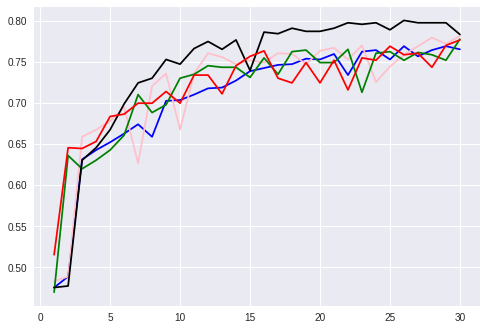

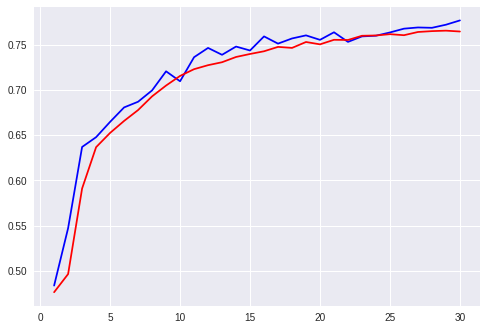

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, 31)


plt.plot(epochs, histories[0].history['val_acc'], 'b')
plt.plot(epochs, histories[1].history['val_acc'], 'pink')
plt.plot(epochs, histories[2].history['val_acc'], 'g')
plt.plot(epochs, histories[3].history['val_acc'], 'black')
plt.plot(epochs, histories[4].history['val_acc'], 'r')
plt.title('Validation accuracy over 5 different folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(epochs, np.mean(val_acc, axis=0), 'b')
plt.plot(epochs, np.mean(acc, axis=0), 'red')
plt.title('Training and validation mean accuracy over 5 different folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

As we can see, the accuracy is increasing over time, probably reaching plateu in the end, but we can perform some longer learning process to investigate it. What is interesting is that validation accuracy is usually higher than training accuracy. Some flow in my script?

### K=5 epochs=50

In [0]:
histories2 = kFolding(5, generateModel, 50, train_images, train_targets)

(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/50
2962/4212 [====================>.........] - ETA: 13s - loss: 1.0634 - acc: 0.4787

4212/4212 [==============================] - 48s 11ms/step - loss: 1.0598 - acc: 0.4796 - val_loss: 1.0435 - val_acc: 0.4886
Epoch 2/50
1840/4212 [============>.................] - ETA: 24s - loss: 1.0413 - acc: 0.4891

4212/4212 [==============================] - 48s 11ms/step - loss: 1.0372 - acc: 0.4824 - val_loss: 1.0099 - val_acc: 0.4886
Epoch 3/50
1420/4212 [=========>....................] - ETA: 29s - loss: 1.0054 - acc: 0.4873

4212/4212 [==============================] - 48s 11ms/step - loss: 0.9706 - acc: 0.5214 - val_loss: 0.9036 - val_acc: 0.5913
Epoch 4/50
1283/4212 [========>.....................] - ETA: 30s - loss: 0.9162 - acc: 0.5838

4212/4212 [==============================] - 48s 11ms/step - loss: 0.8667 - acc: 0.6216 - val_loss: 0.8138 - val_acc: 0.6264
Epoch 5/50
1203/4212 [=======>......................] - ETA: 31s - loss: 0.7991 - acc: 0.6434

4212/4212 [==============================] - 48s 11ms/step - loss: 0.7983 - acc: 0.6384 - val_loss: 0.7338 - val_acc: 0.6559
Epoch 6/50
1174/4212 [=======>......................] - ETA: 32s - loss: 0.7715 - acc: 0.6329

4212/4212 [==============================] - 48s 11ms/step - loss: 0.7635 - acc: 0.6465 - val_loss: 0.7085 - val_acc: 0.6578
Epoch 7/50
1186/4212 [=======>......................] - ETA: 31s - loss: 0.7376 - acc: 0.6535

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7401 - acc: 0.6586 - val_loss: 0.6803 - val_acc: 0.6873
Epoch 8/50
1191/4212 [=======>......................] - ETA: 31s - loss: 0.7280 - acc: 0.6784

4212/4212 [==============================] - 48s 11ms/step - loss: 0.7166 - acc: 0.6816 - val_loss: 0.6536 - val_acc: 0.6987
Epoch 9/50
1164/4212 [=======>......................] - ETA: 32s - loss: 0.6958 - acc: 0.7002

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6975 - acc: 0.6918 - val_loss: 0.6666 - val_acc: 0.6797
Epoch 10/50
1176/4212 [=======>......................] - ETA: 32s - loss: 0.7069 - acc: 0.6922

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6821 - acc: 0.7068 - val_loss: 0.6255 - val_acc: 0.7300
Epoch 11/50
1175/4212 [=======>......................] - ETA: 31s - loss: 0.6560 - acc: 0.7319

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6728 - acc: 0.7153 - val_loss: 0.6065 - val_acc: 0.7386
Epoch 12/50
1147/4212 [=======>......................] - ETA: 32s - loss: 0.6842 - acc: 0.7097

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6562 - acc: 0.7232 - val_loss: 0.6587 - val_acc: 0.7405
Epoch 13/50
1143/4212 [=======>......................] - ETA: 32s - loss: 0.6323 - acc: 0.7305

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6553 - acc: 0.7298 - val_loss: 0.6058 - val_acc: 0.7652
Epoch 14/50
1172/4212 [=======>......................] - ETA: 31s - loss: 0.6388 - acc: 0.7338

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6413 - acc: 0.7374 - val_loss: 0.5787 - val_acc: 0.7586
Epoch 15/50
1194/4212 [=======>......................] - ETA: 31s - loss: 0.6401 - acc: 0.7203

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6351 - acc: 0.7272 - val_loss: 0.6684 - val_acc: 0.7262
Epoch 16/50
1163/4212 [=======>......................] - ETA: 32s - loss: 0.6504 - acc: 0.7455

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6242 - acc: 0.7436 - val_loss: 0.5803 - val_acc: 0.7605
Epoch 17/50
1166/4212 [=======>......................] - ETA: 32s - loss: 0.6168 - acc: 0.7401

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6225 - acc: 0.7417 - val_loss: 0.5675 - val_acc: 0.7728
Epoch 18/50
1174/4212 [=======>......................] - ETA: 31s - loss: 0.6175 - acc: 0.7436

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6142 - acc: 0.7438 - val_loss: 0.5590 - val_acc: 0.7757
Epoch 19/50
1158/4212 [=======>......................] - ETA: 32s - loss: 0.5939 - acc: 0.7599

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6029 - acc: 0.7552 - val_loss: 0.5786 - val_acc: 0.7728
Epoch 20/50
1168/4212 [=======>......................] - ETA: 32s - loss: 0.6145 - acc: 0.7534

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5994 - acc: 0.7545 - val_loss: 0.5873 - val_acc: 0.7567
Epoch 21/50
1155/4212 [=======>......................] - ETA: 32s - loss: 0.5783 - acc: 0.7723

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5977 - acc: 0.7571 - val_loss: 0.5547 - val_acc: 0.7804
Epoch 22/50
1137/4212 [=======>......................] - ETA: 32s - loss: 0.5637 - acc: 0.7766

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5911 - acc: 0.7581 - val_loss: 0.5416 - val_acc: 0.7928
Epoch 23/50
1161/4212 [=======>......................] - ETA: 32s - loss: 0.5972 - acc: 0.7597

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5978 - acc: 0.7595 - val_loss: 0.5402 - val_acc: 0.7833
Epoch 24/50
1159/4212 [=======>......................] - ETA: 32s - loss: 0.5796 - acc: 0.7567

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5825 - acc: 0.7633 - val_loss: 0.5332 - val_acc: 0.7909
Epoch 25/50
1155/4212 [=======>......................] - ETA: 32s - loss: 0.6052 - acc: 0.7455

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5777 - acc: 0.7628 - val_loss: 0.5297 - val_acc: 0.7871
Epoch 26/50
1156/4212 [=======>......................] - ETA: 32s - loss: 0.5549 - acc: 0.7777

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5806 - acc: 0.7635 - val_loss: 0.5309 - val_acc: 0.7909
Epoch 27/50
1136/4212 [=======>......................] - ETA: 33s - loss: 0.5502 - acc: 0.7755

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5786 - acc: 0.7628 - val_loss: 0.5266 - val_acc: 0.7909
Epoch 28/50
1143/4212 [=======>......................] - ETA: 32s - loss: 0.5867 - acc: 0.7664

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5691 - acc: 0.7680 - val_loss: 0.5265 - val_acc: 0.7909
Epoch 29/50
1147/4212 [=======>......................] - ETA: 32s - loss: 0.5808 - acc: 0.7594

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5642 - acc: 0.7690 - val_loss: 0.5209 - val_acc: 0.7928
Epoch 30/50
1158/4212 [=======>......................] - ETA: 32s - loss: 0.5358 - acc: 0.7927

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5689 - acc: 0.7661 - val_loss: 0.5229 - val_acc: 0.7899
Epoch 31/50
1171/4212 [=======>......................] - ETA: 31s - loss: 0.5578 - acc: 0.7805

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5658 - acc: 0.7654 - val_loss: 0.5378 - val_acc: 0.7833
Epoch 32/50
1187/4212 [=======>......................] - ETA: 31s - loss: 0.5537 - acc: 0.7751

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5621 - acc: 0.7709 - val_loss: 0.5151 - val_acc: 0.7956
Epoch 33/50
1202/4212 [=======>......................] - ETA: 31s - loss: 0.5741 - acc: 0.7579

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5609 - acc: 0.7735 - val_loss: 0.5213 - val_acc: 0.7928
Epoch 34/50
1259/4212 [=======>......................] - ETA: 30s - loss: 0.5676 - acc: 0.7697

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5626 - acc: 0.7745 - val_loss: 0.5155 - val_acc: 0.7928
Epoch 35/50
1268/4212 [========>.....................] - ETA: 30s - loss: 0.5426 - acc: 0.7910

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5627 - acc: 0.7730 - val_loss: 0.5131 - val_acc: 0.7909
Epoch 36/50
1271/4212 [========>.....................] - ETA: 30s - loss: 0.5797 - acc: 0.7490

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5482 - acc: 0.7707 - val_loss: 0.5437 - val_acc: 0.7890
Epoch 37/50
1272/4212 [========>.....................] - ETA: 30s - loss: 0.5665 - acc: 0.7728

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5597 - acc: 0.7692 - val_loss: 0.5113 - val_acc: 0.7909
Epoch 38/50
1233/4212 [=======>......................] - ETA: 31s - loss: 0.5533 - acc: 0.7737

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5609 - acc: 0.7723 - val_loss: 0.5578 - val_acc: 0.7823
Epoch 39/50
1233/4212 [=======>......................] - ETA: 30s - loss: 0.6019 - acc: 0.7575

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5565 - acc: 0.7733 - val_loss: 0.5229 - val_acc: 0.7861
Epoch 40/50
1291/4212 [========>.....................] - ETA: 29s - loss: 0.5610 - acc: 0.7738

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5634 - acc: 0.7716 - val_loss: 0.5251 - val_acc: 0.7956
Epoch 41/50
1261/4212 [=======>......................] - ETA: 30s - loss: 0.5711 - acc: 0.7462

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5527 - acc: 0.7709 - val_loss: 0.5193 - val_acc: 0.7880
Epoch 42/50
1276/4212 [========>.....................] - ETA: 30s - loss: 0.5591 - acc: 0.7766

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5484 - acc: 0.7787 - val_loss: 0.5220 - val_acc: 0.7833
Epoch 43/50
1288/4212 [========>.....................] - ETA: 29s - loss: 0.5594 - acc: 0.7733

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5524 - acc: 0.7711 - val_loss: 0.5103 - val_acc: 0.7918
Epoch 44/50
1306/4212 [========>.....................] - ETA: 29s - loss: 0.5225 - acc: 0.7963

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5423 - acc: 0.7802 - val_loss: 0.5363 - val_acc: 0.7823
Epoch 45/50
1311/4212 [========>.....................] - ETA: 29s - loss: 0.5481 - acc: 0.7704

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5501 - acc: 0.7735 - val_loss: 0.5187 - val_acc: 0.7861
Epoch 46/50
1319/4212 [========>.....................] - ETA: 29s - loss: 0.5219 - acc: 0.7923

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5478 - acc: 0.7787 - val_loss: 0.5629 - val_acc: 0.7757
Epoch 47/50
1324/4212 [========>.....................] - ETA: 29s - loss: 0.5345 - acc: 0.7825

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5424 - acc: 0.7813 - val_loss: 0.5140 - val_acc: 0.7852
Epoch 48/50
1309/4212 [========>.....................] - ETA: 29s - loss: 0.5697 - acc: 0.7792

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5536 - acc: 0.7752 - val_loss: 0.5064 - val_acc: 0.7928
Epoch 49/50
1282/4212 [========>.....................] - ETA: 30s - loss: 0.5327 - acc: 0.8003

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5486 - acc: 0.7792 - val_loss: 0.5103 - val_acc: 0.7956
Epoch 50/50
1300/4212 [========>.....................] - ETA: 30s - loss: 0.5197 - acc: 0.7892

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5486 - acc: 0.7730 - val_loss: 0.5112 - val_acc: 0.7842
Fold 0 done. Final accuracy: 0.7730294396961064.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/50
 793/4212 [====>.........................] - ETA: 37s - loss: 1.0681 - acc: 0.4628

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0538 - acc: 0.4812 - val_loss: 1.0368 - val_acc: 0.4791
Epoch 2/50
1105/4212 [======>.......................] - ETA: 31s - loss: 1.0451 - acc: 0.4697

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0118 - acc: 0.4891 - val_loss: 0.9548 - val_acc: 0.5152
Epoch 3/50
1200/4212 [=======>......................] - ETA: 31s - loss: 0.9546 - acc: 0.5650

4212/4212 [==============================] - 47s 11ms/step - loss: 0.8946 - acc: 0.6007 - val_loss: 0.8135 - val_acc: 0.6407
Epoch 4/50
1236/4212 [=======>......................] - ETA: 30s - loss: 0.8186 - acc: 0.6319

4212/4212 [==============================] - 47s 11ms/step - loss: 0.8043 - acc: 0.6301 - val_loss: 0.7576 - val_acc: 0.6521
Epoch 5/50
1263/4212 [=======>......................] - ETA: 30s - loss: 0.7856 - acc: 0.6382

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7727 - acc: 0.6422 - val_loss: 0.7364 - val_acc: 0.6625
Epoch 6/50
1256/4212 [=======>......................] - ETA: 30s - loss: 0.7392 - acc: 0.6632

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7515 - acc: 0.6579 - val_loss: 0.7627 - val_acc: 0.6673
Epoch 7/50
1300/4212 [========>.....................] - ETA: 29s - loss: 0.7400 - acc: 0.6700

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7277 - acc: 0.6736 - val_loss: 0.6879 - val_acc: 0.7253
Epoch 8/50
1291/4212 [========>.....................] - ETA: 30s - loss: 0.7045 - acc: 0.6971

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7090 - acc: 0.6890 - val_loss: 0.6832 - val_acc: 0.7167
Epoch 9/50
1285/4212 [========>.....................] - ETA: 30s - loss: 0.6868 - acc: 0.7051

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6924 - acc: 0.7009 - val_loss: 0.6475 - val_acc: 0.7348
Epoch 10/50
1276/4212 [========>.....................] - ETA: 30s - loss: 0.6726 - acc: 0.7234

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6863 - acc: 0.7056 - val_loss: 0.6358 - val_acc: 0.7500
Epoch 11/50
1253/4212 [=======>......................] - ETA: 30s - loss: 0.6738 - acc: 0.7151

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6743 - acc: 0.7175 - val_loss: 0.6421 - val_acc: 0.7433
Epoch 12/50
1226/4212 [=======>......................] - ETA: 31s - loss: 0.6803 - acc: 0.7178

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6584 - acc: 0.7222 - val_loss: 0.6348 - val_acc: 0.7329
Epoch 13/50
1290/4212 [========>.....................] - ETA: 29s - loss: 0.6597 - acc: 0.7233

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6509 - acc: 0.7251 - val_loss: 0.6032 - val_acc: 0.7700
Epoch 14/50
1277/4212 [========>.....................] - ETA: 30s - loss: 0.6657 - acc: 0.7142

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6427 - acc: 0.7327 - val_loss: 0.5935 - val_acc: 0.7681
Epoch 15/50
1323/4212 [========>.....................] - ETA: 29s - loss: 0.6619 - acc: 0.7234

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6377 - acc: 0.7301 - val_loss: 0.5933 - val_acc: 0.7681
Epoch 16/50
1323/4212 [========>.....................] - ETA: 29s - loss: 0.6596 - acc: 0.7279

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6323 - acc: 0.7358 - val_loss: 0.5970 - val_acc: 0.7738
Epoch 17/50
1347/4212 [========>.....................] - ETA: 29s - loss: 0.6272 - acc: 0.7313

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6285 - acc: 0.7381 - val_loss: 0.5781 - val_acc: 0.7757
Epoch 18/50
1305/4212 [========>.....................] - ETA: 29s - loss: 0.6233 - acc: 0.7464

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6228 - acc: 0.7377 - val_loss: 0.5656 - val_acc: 0.7785
Epoch 19/50
1273/4212 [========>.....................] - ETA: 30s - loss: 0.6307 - acc: 0.7368

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6134 - acc: 0.7441 - val_loss: 0.5611 - val_acc: 0.7823
Epoch 20/50
1294/4212 [========>.....................] - ETA: 30s - loss: 0.6055 - acc: 0.7496

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6097 - acc: 0.7476 - val_loss: 0.5575 - val_acc: 0.7861
Epoch 21/50
1282/4212 [========>.....................] - ETA: 30s - loss: 0.5984 - acc: 0.7566

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6021 - acc: 0.7493 - val_loss: 0.7294 - val_acc: 0.7414
Epoch 22/50
1312/4212 [========>.....................] - ETA: 29s - loss: 0.6181 - acc: 0.7370

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6041 - acc: 0.7460 - val_loss: 0.5455 - val_acc: 0.7823
Epoch 23/50
1348/4212 [========>.....................] - ETA: 29s - loss: 0.6241 - acc: 0.7374

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5957 - acc: 0.7562 - val_loss: 0.6643 - val_acc: 0.7624
Epoch 24/50
1335/4212 [========>.....................] - ETA: 29s - loss: 0.5816 - acc: 0.7521

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5981 - acc: 0.7469 - val_loss: 0.5761 - val_acc: 0.7766
Epoch 25/50
1271/4212 [========>.....................] - ETA: 30s - loss: 0.5821 - acc: 0.7718

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5915 - acc: 0.7528 - val_loss: 0.5352 - val_acc: 0.8004
Epoch 26/50
1309/4212 [========>.....................] - ETA: 29s - loss: 0.5937 - acc: 0.7548

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5833 - acc: 0.7536 - val_loss: 0.5813 - val_acc: 0.7823
Epoch 27/50
1298/4212 [========>.....................] - ETA: 29s - loss: 0.5929 - acc: 0.7589

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5873 - acc: 0.7564 - val_loss: 0.6352 - val_acc: 0.7367
Epoch 28/50
1297/4212 [========>.....................] - ETA: 29s - loss: 0.5752 - acc: 0.7502

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5854 - acc: 0.7585 - val_loss: 0.5394 - val_acc: 0.7928
Epoch 29/50
1287/4212 [========>.....................] - ETA: 30s - loss: 0.5871 - acc: 0.7545

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5810 - acc: 0.7600 - val_loss: 0.5442 - val_acc: 0.7880
Epoch 30/50
1258/4212 [=======>......................] - ETA: 30s - loss: 0.5722 - acc: 0.7631

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5687 - acc: 0.7638 - val_loss: 0.5365 - val_acc: 0.7804
Epoch 31/50
1243/4212 [=======>......................] - ETA: 30s - loss: 0.6019 - acc: 0.7498

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5711 - acc: 0.7623 - val_loss: 0.5598 - val_acc: 0.7766
Epoch 32/50
1275/4212 [========>.....................] - ETA: 30s - loss: 0.5686 - acc: 0.7757

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5716 - acc: 0.7645 - val_loss: 0.5124 - val_acc: 0.8042
Epoch 33/50
1270/4212 [========>.....................] - ETA: 30s - loss: 0.5699 - acc: 0.7614

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5694 - acc: 0.7683 - val_loss: 0.5744 - val_acc: 0.7871
Epoch 34/50
1316/4212 [========>.....................] - ETA: 29s - loss: 0.5513 - acc: 0.7796

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5628 - acc: 0.7721 - val_loss: 0.5111 - val_acc: 0.7994
Epoch 35/50
1284/4212 [========>.....................] - ETA: 30s - loss: 0.5976 - acc: 0.7438

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5610 - acc: 0.7695 - val_loss: 0.5314 - val_acc: 0.7994
Epoch 36/50
1301/4212 [========>.....................] - ETA: 29s - loss: 0.5792 - acc: 0.7625

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5579 - acc: 0.7669 - val_loss: 0.5156 - val_acc: 0.7975
Epoch 37/50
1270/4212 [========>.....................] - ETA: 30s - loss: 0.5862 - acc: 0.7575

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5500 - acc: 0.7759 - val_loss: 0.5121 - val_acc: 0.8023
Epoch 38/50
1304/4212 [========>.....................] - ETA: 29s - loss: 0.5189 - acc: 0.7730

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5551 - acc: 0.7733 - val_loss: 0.5120 - val_acc: 0.7956
Epoch 39/50
1296/4212 [========>.....................] - ETA: 29s - loss: 0.5411 - acc: 0.7793

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5474 - acc: 0.7754 - val_loss: 0.4893 - val_acc: 0.8108
Epoch 40/50
1260/4212 [=======>......................] - ETA: 30s - loss: 0.5661 - acc: 0.7706

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5582 - acc: 0.7714 - val_loss: 0.5246 - val_acc: 0.7918
Epoch 41/50
1269/4212 [========>.....................] - ETA: 30s - loss: 0.5253 - acc: 0.7801

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5433 - acc: 0.7726 - val_loss: 0.5936 - val_acc: 0.7700
Epoch 42/50
1259/4212 [=======>......................] - ETA: 30s - loss: 0.5568 - acc: 0.7720

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5463 - acc: 0.7740 - val_loss: 0.4873 - val_acc: 0.8089
Epoch 43/50
1266/4212 [========>.....................] - ETA: 30s - loss: 0.5420 - acc: 0.7765

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5426 - acc: 0.7768 - val_loss: 0.5287 - val_acc: 0.8013
Epoch 44/50
1242/4212 [=======>......................] - ETA: 30s - loss: 0.5520 - acc: 0.7762

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5401 - acc: 0.7825 - val_loss: 0.5032 - val_acc: 0.7994
Epoch 45/50
1240/4212 [=======>......................] - ETA: 30s - loss: 0.5541 - acc: 0.7798

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5439 - acc: 0.7799 - val_loss: 0.5087 - val_acc: 0.7937
Epoch 46/50
1235/4212 [=======>......................] - ETA: 30s - loss: 0.5427 - acc: 0.7781

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5479 - acc: 0.7759 - val_loss: 0.4927 - val_acc: 0.8051
Epoch 47/50
1277/4212 [========>.....................] - ETA: 30s - loss: 0.5316 - acc: 0.7792

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5419 - acc: 0.7816 - val_loss: 0.4960 - val_acc: 0.8023
Epoch 48/50
1279/4212 [========>.....................] - ETA: 30s - loss: 0.5638 - acc: 0.7733

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5516 - acc: 0.7699 - val_loss: 0.5204 - val_acc: 0.7928
Epoch 49/50
1308/4212 [========>.....................] - ETA: 29s - loss: 0.5190 - acc: 0.7959

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5472 - acc: 0.7780 - val_loss: 0.4884 - val_acc: 0.8061
Epoch 50/50
1306/4212 [========>.....................] - ETA: 29s - loss: 0.5522 - acc: 0.7726

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5440 - acc: 0.7740 - val_loss: 0.5151 - val_acc: 0.7985
Fold 1 done. Final accuracy: 0.7739791073124407.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/50
 804/4212 [====>.........................] - ETA: 37s - loss: 1.0645 - acc: 0.4851

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0580 - acc: 0.4846 - val_loss: 1.0611 - val_acc: 0.4686
Epoch 2/50
1087/4212 [======>.......................] - ETA: 32s - loss: 1.0580 - acc: 0.4701

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0370 - acc: 0.4874 - val_loss: 1.0291 - val_acc: 0.4686
Epoch 3/50
1191/4212 [=======>......................] - ETA: 31s - loss: 1.0007 - acc: 0.4962

4212/4212 [==============================] - 46s 11ms/step - loss: 0.9781 - acc: 0.5121 - val_loss: 0.9243 - val_acc: 0.5979
Epoch 4/50
1277/4212 [========>.....................] - ETA: 30s - loss: 0.9070 - acc: 0.5967

4212/4212 [==============================] - 47s 11ms/step - loss: 0.8626 - acc: 0.6208 - val_loss: 0.8148 - val_acc: 0.6359
Epoch 5/50
1270/4212 [========>.....................] - ETA: 30s - loss: 0.8118 - acc: 0.6409

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7804 - acc: 0.6432 - val_loss: 0.7713 - val_acc: 0.6388
Epoch 6/50
1249/4212 [=======>......................] - ETA: 31s - loss: 0.7625 - acc: 0.6525

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7475 - acc: 0.6536 - val_loss: 0.7476 - val_acc: 0.6568
Epoch 7/50
1273/4212 [========>.....................] - ETA: 30s - loss: 0.7224 - acc: 0.6685

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7208 - acc: 0.6688 - val_loss: 0.7377 - val_acc: 0.6702
Epoch 8/50
1243/4212 [=======>......................] - ETA: 30s - loss: 0.7020 - acc: 0.6862

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7036 - acc: 0.6904 - val_loss: 0.7281 - val_acc: 0.6958
Epoch 9/50
1273/4212 [========>.....................] - ETA: 30s - loss: 0.6946 - acc: 0.7007

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6863 - acc: 0.6997 - val_loss: 0.7074 - val_acc: 0.6958
Epoch 10/50
1304/4212 [========>.....................] - ETA: 29s - loss: 0.6773 - acc: 0.7048

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6742 - acc: 0.7096 - val_loss: 0.7360 - val_acc: 0.7110
Epoch 11/50
1265/4212 [========>.....................] - ETA: 30s - loss: 0.6587 - acc: 0.7170

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6612 - acc: 0.7194 - val_loss: 0.6681 - val_acc: 0.7262
Epoch 12/50
1286/4212 [========>.....................] - ETA: 30s - loss: 0.6564 - acc: 0.7154

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6455 - acc: 0.7322 - val_loss: 0.7006 - val_acc: 0.7034
Epoch 13/50
1307/4212 [========>.....................] - ETA: 29s - loss: 0.6046 - acc: 0.7513

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6353 - acc: 0.7350 - val_loss: 0.6582 - val_acc: 0.7291
Epoch 14/50
1316/4212 [========>.....................] - ETA: 29s - loss: 0.6386 - acc: 0.7295

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6298 - acc: 0.7331 - val_loss: 0.6405 - val_acc: 0.7395
Epoch 15/50
1310/4212 [========>.....................] - ETA: 29s - loss: 0.6361 - acc: 0.7359

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6209 - acc: 0.7431 - val_loss: 0.6256 - val_acc: 0.7414
Epoch 16/50
1271/4212 [========>.....................] - ETA: 30s - loss: 0.6137 - acc: 0.7427

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6109 - acc: 0.7443 - val_loss: 0.6173 - val_acc: 0.7481
Epoch 17/50
1233/4212 [=======>......................] - ETA: 31s - loss: 0.5864 - acc: 0.7705

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6007 - acc: 0.7540 - val_loss: 0.6154 - val_acc: 0.7529
Epoch 18/50
1238/4212 [=======>......................] - ETA: 30s - loss: 0.6183 - acc: 0.7359

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5940 - acc: 0.7531 - val_loss: 0.6265 - val_acc: 0.7538
Epoch 19/50
1302/4212 [========>.....................] - ETA: 29s - loss: 0.5736 - acc: 0.7650

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5940 - acc: 0.7574 - val_loss: 0.6120 - val_acc: 0.7605
Epoch 20/50
1286/4212 [========>.....................] - ETA: 30s - loss: 0.5803 - acc: 0.7667

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5874 - acc: 0.7619 - val_loss: 0.6082 - val_acc: 0.7567
Epoch 21/50
1311/4212 [========>.....................] - ETA: 29s - loss: 0.5767 - acc: 0.7689

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5854 - acc: 0.7628 - val_loss: 0.6045 - val_acc: 0.7548
Epoch 22/50
1309/4212 [========>.....................] - ETA: 29s - loss: 0.5877 - acc: 0.7678

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5812 - acc: 0.7678 - val_loss: 0.5987 - val_acc: 0.7652
Epoch 23/50
1316/4212 [========>.....................] - ETA: 29s - loss: 0.5807 - acc: 0.7546

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5775 - acc: 0.7697 - val_loss: 0.6124 - val_acc: 0.7500
Epoch 24/50
1297/4212 [========>.....................] - ETA: 29s - loss: 0.5870 - acc: 0.7548

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5746 - acc: 0.7711 - val_loss: 0.5922 - val_acc: 0.7605
Epoch 25/50
1281/4212 [========>.....................] - ETA: 30s - loss: 0.5698 - acc: 0.7650

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5776 - acc: 0.7657 - val_loss: 0.5916 - val_acc: 0.7481
Epoch 26/50
1293/4212 [========>.....................] - ETA: 30s - loss: 0.5928 - acc: 0.7633

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5739 - acc: 0.7690 - val_loss: 0.5689 - val_acc: 0.7728
Epoch 27/50
1277/4212 [========>.....................] - ETA: 30s - loss: 0.5934 - acc: 0.7572

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5624 - acc: 0.7723 - val_loss: 0.5845 - val_acc: 0.7624
Epoch 28/50
1279/4212 [========>.....................] - ETA: 30s - loss: 0.5525 - acc: 0.7787

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5675 - acc: 0.7697 - val_loss: 0.5778 - val_acc: 0.7567
Epoch 29/50
1245/4212 [=======>......................] - ETA: 31s - loss: 0.5688 - acc: 0.7671

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5559 - acc: 0.7733 - val_loss: 0.6169 - val_acc: 0.7548
Epoch 30/50
1242/4212 [=======>......................] - ETA: 30s - loss: 0.5758 - acc: 0.7689

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5662 - acc: 0.7711 - val_loss: 0.5635 - val_acc: 0.7757
Epoch 31/50
1234/4212 [=======>......................] - ETA: 30s - loss: 0.5453 - acc: 0.7642

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5607 - acc: 0.7733 - val_loss: 0.5937 - val_acc: 0.7538
Epoch 32/50
1243/4212 [=======>......................] - ETA: 30s - loss: 0.5479 - acc: 0.7828

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5550 - acc: 0.7730 - val_loss: 0.6038 - val_acc: 0.7709
Epoch 33/50
1221/4212 [=======>......................] - ETA: 31s - loss: 0.5410 - acc: 0.7895

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5567 - acc: 0.7756 - val_loss: 0.5989 - val_acc: 0.7500
Epoch 34/50
1233/4212 [=======>......................] - ETA: 31s - loss: 0.5754 - acc: 0.7826

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5627 - acc: 0.7787 - val_loss: 0.5652 - val_acc: 0.7738
Epoch 35/50
1244/4212 [=======>......................] - ETA: 31s - loss: 0.5315 - acc: 0.7854

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5515 - acc: 0.7721 - val_loss: 0.5521 - val_acc: 0.7700
Epoch 36/50
1201/4212 [=======>......................] - ETA: 31s - loss: 0.5368 - acc: 0.7877

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5501 - acc: 0.7783 - val_loss: 0.5737 - val_acc: 0.7719
Epoch 37/50
1164/4212 [=======>......................] - ETA: 32s - loss: 0.5705 - acc: 0.7723

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5532 - acc: 0.7740 - val_loss: 0.6120 - val_acc: 0.7481
Epoch 38/50
1147/4212 [=======>......................] - ETA: 32s - loss: 0.5621 - acc: 0.7724

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5429 - acc: 0.7773 - val_loss: 0.5566 - val_acc: 0.7595
Epoch 39/50
1134/4212 [=======>......................] - ETA: 33s - loss: 0.5700 - acc: 0.7698

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5532 - acc: 0.7716 - val_loss: 0.5602 - val_acc: 0.7671
Epoch 40/50
1113/4212 [======>.......................] - ETA: 33s - loss: 0.5461 - acc: 0.7655

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5480 - acc: 0.7747 - val_loss: 0.6198 - val_acc: 0.7538
Epoch 41/50
1172/4212 [=======>......................] - ETA: 31s - loss: 0.5500 - acc: 0.7747

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5357 - acc: 0.7858 - val_loss: 0.5671 - val_acc: 0.7804
Epoch 42/50
1184/4212 [=======>......................] - ETA: 31s - loss: 0.5731 - acc: 0.7576

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5409 - acc: 0.7745 - val_loss: 0.5742 - val_acc: 0.7757
Epoch 43/50
1230/4212 [=======>......................] - ETA: 31s - loss: 0.5681 - acc: 0.7626

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5470 - acc: 0.7785 - val_loss: 0.6151 - val_acc: 0.7605
Epoch 44/50
1205/4212 [=======>......................] - ETA: 31s - loss: 0.5603 - acc: 0.7768

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5395 - acc: 0.7761 - val_loss: 0.5416 - val_acc: 0.7776
Epoch 45/50
1232/4212 [=======>......................] - ETA: 31s - loss: 0.5369 - acc: 0.7768

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5341 - acc: 0.7823 - val_loss: 0.5672 - val_acc: 0.7671
Epoch 46/50
1187/4212 [=======>......................] - ETA: 32s - loss: 0.5107 - acc: 0.7877

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5326 - acc: 0.7809 - val_loss: 0.5354 - val_acc: 0.7671
Epoch 47/50
1227/4212 [=======>......................] - ETA: 30s - loss: 0.5117 - acc: 0.7767

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5336 - acc: 0.7792 - val_loss: 0.5385 - val_acc: 0.7652
Epoch 48/50
1164/4212 [=======>......................] - ETA: 33s - loss: 0.5202 - acc: 0.7912

4212/4212 [==============================] - 49s 12ms/step - loss: 0.5373 - acc: 0.7821 - val_loss: 0.6059 - val_acc: 0.7490
Epoch 49/50
1213/4212 [=======>......................] - ETA: 30s - loss: 0.5401 - acc: 0.7766

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5348 - acc: 0.7844 - val_loss: 0.5288 - val_acc: 0.7738
Epoch 50/50
1276/4212 [========>.....................] - ETA: 30s - loss: 0.5435 - acc: 0.7712

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5355 - acc: 0.7768 - val_loss: 0.6411 - val_acc: 0.7386
Fold 2 done. Final accuracy: 0.7768281101614435.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/50
 815/4212 [====>.........................] - ETA: 37s - loss: 1.0850 - acc: 0.4196

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0530 - acc: 0.4732 - val_loss: 1.0250 - val_acc: 0.4791
Epoch 2/50
1083/4212 [======>.......................] - ETA: 32s - loss: 1.0153 - acc: 0.5014

4212/4212 [==============================] - 47s 11ms/step - loss: 0.9967 - acc: 0.5116 - val_loss: 0.9408 - val_acc: 0.5789
Epoch 3/50
1187/4212 [=======>......................] - ETA: 31s - loss: 0.9251 - acc: 0.5880

4212/4212 [==============================] - 47s 11ms/step - loss: 0.8836 - acc: 0.6170 - val_loss: 0.8268 - val_acc: 0.6644
Epoch 4/50
1224/4212 [=======>......................] - ETA: 30s - loss: 0.8039 - acc: 0.6601

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7825 - acc: 0.6574 - val_loss: 0.7953 - val_acc: 0.6426
Epoch 5/50
1229/4212 [=======>......................] - ETA: 31s - loss: 0.7515 - acc: 0.6688

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7360 - acc: 0.6667 - val_loss: 0.7258 - val_acc: 0.6673
Epoch 6/50
1232/4212 [=======>......................] - ETA: 31s - loss: 0.7039 - acc: 0.6753

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6922 - acc: 0.6847 - val_loss: 0.6899 - val_acc: 0.7025
Epoch 7/50
1195/4212 [=======>......................] - ETA: 31s - loss: 0.6712 - acc: 0.7021

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6739 - acc: 0.7009 - val_loss: 0.6752 - val_acc: 0.7063
Epoch 8/50
1180/4212 [=======>......................] - ETA: 32s - loss: 0.6365 - acc: 0.7280

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6542 - acc: 0.7160 - val_loss: 0.6662 - val_acc: 0.7148
Epoch 9/50
1177/4212 [=======>......................] - ETA: 32s - loss: 0.6282 - acc: 0.7307

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6403 - acc: 0.7255 - val_loss: 0.6640 - val_acc: 0.7063
Epoch 10/50
1175/4212 [=======>......................] - ETA: 31s - loss: 0.6314 - acc: 0.7294

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6316 - acc: 0.7286 - val_loss: 0.6651 - val_acc: 0.7082
Epoch 11/50
1176/4212 [=======>......................] - ETA: 31s - loss: 0.5997 - acc: 0.7491

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6177 - acc: 0.7412 - val_loss: 0.6339 - val_acc: 0.7186
Epoch 12/50
1151/4212 [=======>......................] - ETA: 32s - loss: 0.6445 - acc: 0.7098

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6095 - acc: 0.7407 - val_loss: 0.6642 - val_acc: 0.7110
Epoch 13/50
1175/4212 [=======>......................] - ETA: 31s - loss: 0.6020 - acc: 0.7591

4212/4212 [==============================] - 48s 11ms/step - loss: 0.6092 - acc: 0.7429 - val_loss: 0.6170 - val_acc: 0.7291
Epoch 14/50
1145/4212 [=======>......................] - ETA: 32s - loss: 0.6206 - acc: 0.7336

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6004 - acc: 0.7486 - val_loss: 0.6891 - val_acc: 0.7129
Epoch 15/50
1183/4212 [=======>......................] - ETA: 31s - loss: 0.6057 - acc: 0.7312

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5926 - acc: 0.7500 - val_loss: 0.6319 - val_acc: 0.7348
Epoch 16/50
1207/4212 [=======>......................] - ETA: 31s - loss: 0.6114 - acc: 0.7506

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5945 - acc: 0.7574 - val_loss: 0.6068 - val_acc: 0.7291
Epoch 17/50
1214/4212 [=======>......................] - ETA: 31s - loss: 0.5635 - acc: 0.7628

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5823 - acc: 0.7602 - val_loss: 0.6269 - val_acc: 0.7443
Epoch 18/50
1224/4212 [=======>......................] - ETA: 31s - loss: 0.5976 - acc: 0.7639

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5775 - acc: 0.7609 - val_loss: 0.5960 - val_acc: 0.7395
Epoch 19/50
1240/4212 [=======>......................] - ETA: 30s - loss: 0.5924 - acc: 0.7573

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5784 - acc: 0.7657 - val_loss: 0.6849 - val_acc: 0.7120
Epoch 20/50
1206/4212 [=======>......................] - ETA: 31s - loss: 0.5228 - acc: 0.7844

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5728 - acc: 0.7650 - val_loss: 0.5872 - val_acc: 0.7510
Epoch 21/50
1256/4212 [=======>......................] - ETA: 30s - loss: 0.5688 - acc: 0.7707

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5723 - acc: 0.7640 - val_loss: 0.5779 - val_acc: 0.7490
Epoch 22/50
1251/4212 [=======>......................] - ETA: 30s - loss: 0.5520 - acc: 0.7802

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5625 - acc: 0.7638 - val_loss: 0.6126 - val_acc: 0.7519
Epoch 23/50
1281/4212 [========>.....................] - ETA: 30s - loss: 0.5763 - acc: 0.7689

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5630 - acc: 0.7714 - val_loss: 0.5907 - val_acc: 0.7471
Epoch 24/50
1237/4212 [=======>......................] - ETA: 31s - loss: 0.5476 - acc: 0.7672

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5593 - acc: 0.7690 - val_loss: 0.6240 - val_acc: 0.7500
Epoch 25/50
1230/4212 [=======>......................] - ETA: 30s - loss: 0.5646 - acc: 0.7756

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5620 - acc: 0.7747 - val_loss: 0.5906 - val_acc: 0.7567
Epoch 26/50
1215/4212 [=======>......................] - ETA: 31s - loss: 0.5887 - acc: 0.7630

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5616 - acc: 0.7702 - val_loss: 0.5834 - val_acc: 0.7538
Epoch 27/50
1223/4212 [=======>......................] - ETA: 31s - loss: 0.5240 - acc: 0.7800

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5492 - acc: 0.7737 - val_loss: 0.6055 - val_acc: 0.7386
Epoch 28/50
1204/4212 [=======>......................] - ETA: 32s - loss: 0.5232 - acc: 0.7932

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5536 - acc: 0.7759 - val_loss: 0.5695 - val_acc: 0.7500
Epoch 29/50
1157/4212 [=======>......................] - ETA: 32s - loss: 0.5256 - acc: 0.7813

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5468 - acc: 0.7756 - val_loss: 0.5725 - val_acc: 0.7500
Epoch 30/50
1177/4212 [=======>......................] - ETA: 31s - loss: 0.5438 - acc: 0.7689

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5545 - acc: 0.7676 - val_loss: 0.5779 - val_acc: 0.7595
Epoch 31/50
1272/4212 [========>.....................] - ETA: 29s - loss: 0.5215 - acc: 0.8042

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5511 - acc: 0.7761 - val_loss: 0.5635 - val_acc: 0.7462
Epoch 32/50
1205/4212 [=======>......................] - ETA: 31s - loss: 0.5792 - acc: 0.7668

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5492 - acc: 0.7766 - val_loss: 0.6327 - val_acc: 0.7386
Epoch 33/50
1159/4212 [=======>......................] - ETA: 32s - loss: 0.5555 - acc: 0.7783

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5474 - acc: 0.7773 - val_loss: 0.6592 - val_acc: 0.7500
Epoch 34/50
1176/4212 [=======>......................] - ETA: 32s - loss: 0.5521 - acc: 0.7815

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5491 - acc: 0.7773 - val_loss: 0.5993 - val_acc: 0.7500
Epoch 35/50
1161/4212 [=======>......................] - ETA: 32s - loss: 0.5466 - acc: 0.7795

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5460 - acc: 0.7778 - val_loss: 0.5725 - val_acc: 0.7595
Epoch 36/50
1204/4212 [=======>......................] - ETA: 31s - loss: 0.5288 - acc: 0.7890

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5511 - acc: 0.7802 - val_loss: 0.5652 - val_acc: 0.7538
Epoch 37/50
1186/4212 [=======>......................] - ETA: 31s - loss: 0.5647 - acc: 0.7782

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5418 - acc: 0.7785 - val_loss: 0.6907 - val_acc: 0.7452
Epoch 38/50
1183/4212 [=======>......................] - ETA: 31s - loss: 0.5724 - acc: 0.7633

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5475 - acc: 0.7778 - val_loss: 0.5922 - val_acc: 0.7529
Epoch 39/50
1161/4212 [=======>......................] - ETA: 32s - loss: 0.5551 - acc: 0.7717

4212/4212 [==============================] - 48s 11ms/step - loss: 0.5478 - acc: 0.7749 - val_loss: 0.6537 - val_acc: 0.7490
Epoch 40/50
1165/4212 [=======>......................] - ETA: 32s - loss: 0.5604 - acc: 0.7768

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5434 - acc: 0.7821 - val_loss: 0.6416 - val_acc: 0.7471
Epoch 41/50
1176/4212 [=======>......................] - ETA: 32s - loss: 0.5402 - acc: 0.7772

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5463 - acc: 0.7780 - val_loss: 0.6436 - val_acc: 0.7500
Epoch 42/50
1155/4212 [=======>......................] - ETA: 32s - loss: 0.5362 - acc: 0.7775

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5436 - acc: 0.7775 - val_loss: 0.5716 - val_acc: 0.7567
Epoch 43/50
1217/4212 [=======>......................] - ETA: 31s - loss: 0.5317 - acc: 0.7716

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5427 - acc: 0.7778 - val_loss: 0.6054 - val_acc: 0.7690
Epoch 44/50
1216/4212 [=======>......................] - ETA: 30s - loss: 0.5481 - acc: 0.7854

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5545 - acc: 0.7783 - val_loss: 0.5576 - val_acc: 0.7586
Epoch 45/50
1312/4212 [========>.....................] - ETA: 29s - loss: 0.5113 - acc: 0.7889

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5366 - acc: 0.7840 - val_loss: 0.5789 - val_acc: 0.7529
Epoch 46/50
1323/4212 [========>.....................] - ETA: 29s - loss: 0.5726 - acc: 0.7634

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5371 - acc: 0.7813 - val_loss: 0.5993 - val_acc: 0.7605
Epoch 47/50
1304/4212 [========>.....................] - ETA: 30s - loss: 0.5495 - acc: 0.7837

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5398 - acc: 0.7866 - val_loss: 0.5647 - val_acc: 0.7586
Epoch 48/50
1261/4212 [=======>......................] - ETA: 30s - loss: 0.5399 - acc: 0.7748

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5373 - acc: 0.7802 - val_loss: 0.5676 - val_acc: 0.7567
Epoch 49/50
1266/4212 [========>.....................] - ETA: 30s - loss: 0.5111 - acc: 0.7867

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5443 - acc: 0.7778 - val_loss: 0.5764 - val_acc: 0.7662
Epoch 50/50
1266/4212 [========>.....................] - ETA: 30s - loss: 0.4944 - acc: 0.8065

4212/4212 [==============================] - 46s 11ms/step - loss: 0.5365 - acc: 0.7811 - val_loss: 0.5920 - val_acc: 0.7633
Fold 3 done. Final accuracy: 0.7811016144349477.
(1052, 150, 105, 3) (1052, 3)
Train on 4212 samples, validate on 1052 samples
Epoch 1/50
 797/4212 [====>.........................] - ETA: 38s - loss: 1.0747 - acc: 0.4404

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0596 - acc: 0.4734 - val_loss: 1.0316 - val_acc: 0.5019
Epoch 2/50
1086/4212 [======>.......................] - ETA: 32s - loss: 1.0435 - acc: 0.4807

4212/4212 [==============================] - 47s 11ms/step - loss: 1.0309 - acc: 0.4791 - val_loss: 0.9879 - val_acc: 0.5057
Epoch 3/50
1202/4212 [=======>......................] - ETA: 30s - loss: 0.9827 - acc: 0.5017

4212/4212 [==============================] - 47s 11ms/step - loss: 0.9550 - acc: 0.5430 - val_loss: 0.9318 - val_acc: 0.5960
Epoch 4/50
1242/4212 [=======>......................] - ETA: 30s - loss: 0.8794 - acc: 0.6272

4212/4212 [==============================] - 47s 11ms/step - loss: 0.8502 - acc: 0.6254 - val_loss: 0.7997 - val_acc: 0.6511
Epoch 5/50
1258/4212 [=======>......................] - ETA: 30s - loss: 0.8151 - acc: 0.6304

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7931 - acc: 0.6384 - val_loss: 0.7552 - val_acc: 0.6730
Epoch 6/50
1287/4212 [========>.....................] - ETA: 30s - loss: 0.7668 - acc: 0.6550

4212/4212 [==============================] - 46s 11ms/step - loss: 0.7578 - acc: 0.6527 - val_loss: 0.7159 - val_acc: 0.6873
Epoch 7/50
1284/4212 [========>.....................] - ETA: 30s - loss: 0.7408 - acc: 0.6674

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7280 - acc: 0.6752 - val_loss: 0.6876 - val_acc: 0.7034
Epoch 8/50
1297/4212 [========>.....................] - ETA: 29s - loss: 0.7166 - acc: 0.6808

4212/4212 [==============================] - 47s 11ms/step - loss: 0.7039 - acc: 0.6890 - val_loss: 0.6753 - val_acc: 0.7215
Epoch 9/50
1283/4212 [========>.....................] - ETA: 30s - loss: 0.7145 - acc: 0.6859

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6846 - acc: 0.7035 - val_loss: 0.6430 - val_acc: 0.7291
Epoch 10/50
1274/4212 [========>.....................] - ETA: 30s - loss: 0.6872 - acc: 0.6970

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6797 - acc: 0.7096 - val_loss: 0.6258 - val_acc: 0.7424
Epoch 11/50
1275/4212 [========>.....................] - ETA: 30s - loss: 0.6601 - acc: 0.7161

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6588 - acc: 0.7196 - val_loss: 0.6811 - val_acc: 0.7300
Epoch 12/50
1282/4212 [========>.....................] - ETA: 30s - loss: 0.6489 - acc: 0.7239

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6399 - acc: 0.7293 - val_loss: 0.6086 - val_acc: 0.7557
Epoch 13/50
1239/4212 [=======>......................] - ETA: 31s - loss: 0.6537 - acc: 0.7119

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6419 - acc: 0.7289 - val_loss: 0.6224 - val_acc: 0.7405
Epoch 14/50
1260/4212 [=======>......................] - ETA: 30s - loss: 0.6436 - acc: 0.7397

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6257 - acc: 0.7403 - val_loss: 0.5792 - val_acc: 0.7709
Epoch 15/50
1235/4212 [=======>......................] - ETA: 30s - loss: 0.6541 - acc: 0.7287

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6246 - acc: 0.7346 - val_loss: 0.5803 - val_acc: 0.7605
Epoch 16/50
1259/4212 [=======>......................] - ETA: 30s - loss: 0.6266 - acc: 0.7395

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6181 - acc: 0.7441 - val_loss: 0.5614 - val_acc: 0.7785
Epoch 17/50
1251/4212 [=======>......................] - ETA: 30s - loss: 0.6130 - acc: 0.7506

4212/4212 [==============================] - 46s 11ms/step - loss: 0.6154 - acc: 0.7438 - val_loss: 0.5646 - val_acc: 0.7557
Epoch 18/50
1260/4212 [=======>......................] - ETA: 30s - loss: 0.6194 - acc: 0.7349

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6014 - acc: 0.7517 - val_loss: 0.6454 - val_acc: 0.7053
Epoch 19/50
1255/4212 [=======>......................] - ETA: 30s - loss: 0.6219 - acc: 0.7307

4212/4212 [==============================] - 47s 11ms/step - loss: 0.6039 - acc: 0.7486 - val_loss: 0.5391 - val_acc: 0.7823
Epoch 20/50
1292/4212 [========>.....................] - ETA: 30s - loss: 0.6097 - acc: 0.7438

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5974 - acc: 0.7514 - val_loss: 0.5444 - val_acc: 0.7690
Epoch 21/50
1262/4212 [=======>......................] - ETA: 30s - loss: 0.5789 - acc: 0.7805

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5881 - acc: 0.7588 - val_loss: 0.5275 - val_acc: 0.7785
Epoch 22/50
1258/4212 [=======>......................] - ETA: 30s - loss: 0.5820 - acc: 0.7719

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5830 - acc: 0.7633 - val_loss: 0.5850 - val_acc: 0.7557
Epoch 23/50
1259/4212 [=======>......................] - ETA: 30s - loss: 0.5915 - acc: 0.7474

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5904 - acc: 0.7609 - val_loss: 0.5293 - val_acc: 0.7852
Epoch 24/50
1266/4212 [========>.....................] - ETA: 30s - loss: 0.5746 - acc: 0.7717

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5861 - acc: 0.7583 - val_loss: 0.5505 - val_acc: 0.7776
Epoch 25/50
1271/4212 [========>.....................] - ETA: 30s - loss: 0.5878 - acc: 0.7671

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5743 - acc: 0.7704 - val_loss: 0.5474 - val_acc: 0.7795
Epoch 26/50
1257/4212 [=======>......................] - ETA: 30s - loss: 0.5666 - acc: 0.7629

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5832 - acc: 0.7590 - val_loss: 0.5516 - val_acc: 0.7709
Epoch 27/50
1269/4212 [========>.....................] - ETA: 30s - loss: 0.5593 - acc: 0.7730

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5652 - acc: 0.7685 - val_loss: 0.5112 - val_acc: 0.7890
Epoch 28/50
1262/4212 [=======>......................] - ETA: 30s - loss: 0.5515 - acc: 0.7821

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5745 - acc: 0.7666 - val_loss: 0.5690 - val_acc: 0.7605
Epoch 29/50
1278/4212 [========>.....................] - ETA: 30s - loss: 0.5667 - acc: 0.7613

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5652 - acc: 0.7657 - val_loss: 0.5276 - val_acc: 0.7909
Epoch 30/50
1251/4212 [=======>......................] - ETA: 30s - loss: 0.5821 - acc: 0.7562

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5696 - acc: 0.7654 - val_loss: 0.5200 - val_acc: 0.7852
Epoch 31/50
1243/4212 [=======>......................] - ETA: 30s - loss: 0.5567 - acc: 0.7763

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5624 - acc: 0.7721 - val_loss: 0.5306 - val_acc: 0.7890
Epoch 32/50
1216/4212 [=======>......................] - ETA: 31s - loss: 0.5664 - acc: 0.7664

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5646 - acc: 0.7721 - val_loss: 0.5190 - val_acc: 0.7833
Epoch 33/50
1271/4212 [========>.....................] - ETA: 30s - loss: 0.5710 - acc: 0.7592

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5618 - acc: 0.7707 - val_loss: 0.5783 - val_acc: 0.7728
Epoch 34/50
1287/4212 [========>.....................] - ETA: 30s - loss: 0.5373 - acc: 0.7988

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5596 - acc: 0.7695 - val_loss: 0.5106 - val_acc: 0.7861
Epoch 35/50
1238/4212 [=======>......................] - ETA: 31s - loss: 0.5713 - acc: 0.7625

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5533 - acc: 0.7702 - val_loss: 0.5269 - val_acc: 0.7709
Epoch 36/50
1250/4212 [=======>......................] - ETA: 30s - loss: 0.5380 - acc: 0.7912

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5509 - acc: 0.7747 - val_loss: 0.4937 - val_acc: 0.8004
Epoch 37/50
1256/4212 [=======>......................] - ETA: 30s - loss: 0.5805 - acc: 0.7659

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5606 - acc: 0.7711 - val_loss: 0.5142 - val_acc: 0.7804
Epoch 38/50
1243/4212 [=======>......................] - ETA: 30s - loss: 0.5897 - acc: 0.7490

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5550 - acc: 0.7721 - val_loss: 0.5228 - val_acc: 0.7899
Epoch 39/50
1237/4212 [=======>......................] - ETA: 30s - loss: 0.5544 - acc: 0.7761

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5496 - acc: 0.7790 - val_loss: 0.5081 - val_acc: 0.7890
Epoch 40/50
1213/4212 [=======>......................] - ETA: 31s - loss: 0.5452 - acc: 0.7634

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5531 - acc: 0.7718 - val_loss: 0.5203 - val_acc: 0.7804
Epoch 41/50
1234/4212 [=======>......................] - ETA: 31s - loss: 0.5447 - acc: 0.7780

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5437 - acc: 0.7764 - val_loss: 0.5166 - val_acc: 0.7909
Epoch 42/50
1242/4212 [=======>......................] - ETA: 30s - loss: 0.5415 - acc: 0.7802

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5516 - acc: 0.7730 - val_loss: 0.4930 - val_acc: 0.7966
Epoch 43/50
1225/4212 [=======>......................] - ETA: 30s - loss: 0.5324 - acc: 0.7747

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5462 - acc: 0.7716 - val_loss: 0.5137 - val_acc: 0.7852
Epoch 44/50
1242/4212 [=======>......................] - ETA: 30s - loss: 0.5143 - acc: 0.7963

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5491 - acc: 0.7764 - val_loss: 0.5632 - val_acc: 0.7681
Epoch 45/50
1255/4212 [=======>......................] - ETA: 30s - loss: 0.4888 - acc: 0.7865

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5460 - acc: 0.7759 - val_loss: 0.5005 - val_acc: 0.7975
Epoch 46/50
1232/4212 [=======>......................] - ETA: 31s - loss: 0.5587 - acc: 0.7695

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5507 - acc: 0.7714 - val_loss: 0.4856 - val_acc: 0.8032
Epoch 47/50
1247/4212 [=======>......................] - ETA: 30s - loss: 0.5492 - acc: 0.7795

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5504 - acc: 0.7764 - val_loss: 0.4887 - val_acc: 0.7966
Epoch 48/50
1205/4212 [=======>......................] - ETA: 31s - loss: 0.5310 - acc: 0.7718

4212/4212 [==============================] - 47s 11ms/step - loss: 0.5387 - acc: 0.7792 - val_loss: 0.4898 - val_acc: 0.7985
Epoch 49/50
1225/4212 [=======>......................] - ETA: 31s - loss: 0.5608 - acc: 0.7584

2541/4212 [=================>............] - ETA: 17s - loss: 0.5353 - acc: 0.7729

In [1]:
histories2[0]

NameError: ignored

### K=3 Epoch=30 New model with more capacity

In [0]:
from keras import models
from keras import layers
from keras import optimizers
import numpy as np

def generateModel2():
  model = models.Sequential()
  model.add(layers.Conv2D(20, (3,3), activation='relu', input_shape=(150, 105, 3)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(40, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(80, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(80, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(3, activation='softmax'))
  model.compile(optimizer = optimizers.RMSprop(lr=1e-5), loss = 'categorical_crossentropy', metrics=['acc'])
  return model